# Setup

In [1]:
%pip install dill
%pip install pyreadr
%pip install scikit-learn
%pip install pandas
%pip install numpy
%pip install xgboost
%pip install -U matplotlib
%pip install typeguard
%pip install PyQt6

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# library to check function types of imported modules
from typeguard import install_import_hook

# custom functions for plotting, etc.
with install_import_hook('custom_ml_plots'):
    import custom_ml_plots as cmp
with install_import_hook('custom_dataset_tools'):
    import custom_dataset_tools as cdt
with install_import_hook('basic_ml_operations'):
    import basic_ml_operations as bmo
with install_import_hook('ml_data_objects'):
    import ml_data_objects as mdo

# data import and export
import pyreadr
import dill

# data management libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# plots
from matplotlib import pyplot as plt

# misc
import os

# Scaling
from sklearn.preprocessing import StandardScaler

# k-fold cross-validation
from sklearn.model_selection import KFold

# global parameters
RANDOM_STATE = 42
TOP_LINE_THRESH = 0.6 # values to test: 0.5, 0.6, 0.7, 0.8, 0.9

## Import Data

In [3]:
# import dataset
eyt1 = pyreadr.read_r('./data/eyt1.RData')

# extract training example labels
y_bin = eyt1['Pheno_Disc_Env1']

y_bin.head()

,GID,Env,DTHD,DTMT,GY,Height
0,GID6569128,Bed5IR,1.0,1.0,6.119272,0.0
1,GID6688880,Bed5IR,2.0,2.0,5.855879,0.0
2,GID6688916,Bed5IR,2.0,2.0,6.434748,0.0
3,GID6688933,Bed5IR,2.0,2.0,6.350670,0.0
4,GID6688934,Bed5IR,1.0,2.0,6.523289,0.0


In [4]:
y_bin = y_bin[['GY']].set_index(y_bin['GID'])

# sort by index
y_bin = y_bin.sort_index()

# check missing values
cdt.assert_no_bad_values(y_bin)

# each seed was planted in 4 different environments, but we don't care about environmental differences
# so we take the average of every group of four rows to reduce the dataset to 1/4 its original size
y_bin = cdt.avg_rows(y_bin, 4)

y_bin.head()

,GY
GID,
GID6569128,5.160521
GID6688880,5.988963
GID6688916,5.781745
GID6688933,5.434369
GID6688934,5.551610


In [5]:
# extract feature matrix
X = eyt1['Geno_Env1']

X.head()
"""
# temporary data override for quick testing
y_bin = pd.DataFrame(data={'GY': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]})
X = pd.DataFrame(data={'rs1': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40],})
"""

## Other

In [6]:
def create_numbered_subdir():
    """
    Creates a new subdirectory within the 'saved_data_and_plots' directory, 
    with a name that is the next available number in sequence, formatted as a 
    three-digit number (e.g., '001', '002', etc.).
    Created: 2024/01/01
    Returns:
        str: The path to the newly created numbered subdirectory.
    """
    # Create parent directory if it doesn't exist
    parent_dir = "saved_data_and_plots"
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
    
    # Find next available number
    existing_dirs = [d for d in os.listdir(parent_dir) 
                    if os.path.isdir(os.path.join(parent_dir, d))]
    existing_nums = [int(d) for d in existing_dirs if d.isdigit()]
    next_num = max(existing_nums + [-1]) + 1
    
    # Create new numbered directory
    new_dir = os.path.join(parent_dir, f"{next_num:03d}")
    os.makedirs(new_dir)
    return new_dir

storage_dir = create_numbered_subdir()

In [7]:
# scale feature matrix
X_scaler = StandardScaler()
X_sc = pd.DataFrame(X_scaler.fit_transform(X), index=X.index, columns=X.columns)

y_scaler = StandardScaler()
y_sc = pd.DataFrame(y_scaler.fit_transform(y_bin), index=y_bin.index, columns=y_bin.columns)

y_sc.head()

,GY
0,-1.647509
1,-1.474087
2,-1.300665
3,-1.127243
4,-0.953821


In [8]:

def plot_shaded_scatter_grids(y_preds_grid: np.ndarray, y_test_grid: np.ndarray, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, pearson_grid: np.ndarray, plot_title: str, i: int) -> plt.Figure:
    """
    Plot predictions vs actuals and colour by pearson coefficient and add best fit
    Created: 2024/11/30
    """
    # create plot of predictions vs actuals
    fig, axs = cmp.create_scatter_grid(y_preds_grid, y_test_grid, axis1_params, axis2_params, f"{plot_title} | Inner Fold {i}")

    # colour by pearson coefficient and add best fit and title
    cmp.color_spectrum(fig, axs, pearson_grid, label="Pearson Coefficient")
    cmp.add_best_fit(axs)

    return fig

In [9]:

def plot_shaded_roc_grids(y_preds_grid: np.ndarray, y_test_grid: np.ndarray, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, f1_grid: np.ndarray, plot_title: str, i: int) -> plt.Figure:
    """
    Plot predictions vs actuals and colour by pearson coefficient and add best fit
    Created: 2024/12/22
    """
    # create plot of predictions vs actuals
    fig, axs = cmp.create_roc_grid(y_preds_grid, y_test_grid, axis1_params, axis2_params, f"{plot_title} | Inner Fold {i}")

    # colour by pearson coefficient and add best fit and title
    cmp.color_spectrum(fig, axs, f1_grid, label="f1 Score")
    cmp.add_best_fit(axs)
    
    return fig

In [10]:
B_average_metrics = pd.DataFrame(columns=['F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])
R_average_metrics = pd.DataFrame(columns=['Pearson', 'F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])
RO_average_metrics = pd.DataFrame(columns=['Pearson', 'F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])

# Add linear regression model metrics from research paper
B_average_metrics.loc['GBLUP'] =  [0.411, 0.696, 0.577, 0.180]
R_average_metrics.loc['GBLUP'] =  [None, 0.215, 0.128, 0.987, 0.164]
RO_average_metrics.loc['GBLUP'] = [None, 0.487, 0.711, 0.699, 0.304]

# Model R

In [11]:
def inner_CV_R(n_splits: int, X : pd.DataFrame, y : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback, kfold_random_state: int, plot_title: str = "", **kwargs):
    """Perform inner cross-validation with grid search to find the best model parameters.
    Created: 2024/12/03
    Parameters:
    -----------
    n_splits : int
        Number of splits for KFold cross-validation.
    X : pd.DataFrame
        Feature data.
    y : pd.DataFrame
        Target data.
    axis1_params : mdo.AxisParams
        Parameter grid for the first axis.
    axis2_params : mdo.AxisParams
        Parameter grid for the second axis.
    train_model_callback : callable
        Callback function to train the model.
    kfold_random_state : int
        Random state for KFold shuffling.
    plot_title : str, optional
        Title for the plot (default is "").
    **kwargs : dict
        Additional keyword arguments for the model training.
    Returns:
    --------
    avg_best_param1 : float
        Average best parameter value for the first axis over all folds.
    avg_best_param2 : float
        Average best parameter value for the second axis over all folds."""

    # Create KFold object for inner-fold cross-validation
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_random_state)

    # Store best parameters (C, gamma) for each fold
    best_params = pd.DataFrame(columns=['param1', 'param2'], index=range(n_splits))

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        print(f"    INNER FOLD {i}")
        
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train numpy 2D array of models with every combination of parameters
        model_grid = bmo.train_model_grid(X_train, y_train, axis1_params, axis2_params, train_model_callback, **kwargs)

        # Use trained models to predict test set labels, and store in 2D array with each cell corresponding to a model with specific combination of parameters
        y_preds_grid = bmo.grid_predict(X_test, model_grid)

        # Create 2D array of identical dataframes containing actual labels to compare against predictions
        y_test_grid = cdt.np_array_of_dfs(y_test, y_preds_grid.shape)

        # Evaluate predictions by comparing to actuals, calculating 2D array of pearson coefficients
        pearson_grid = bmo.calculate_pearson_coefficients(y_preds_grid, y_test_grid)

        # Find index of best pearson coefficient in the 2d array of pearson coefficients
        best_row, best_col = np.unravel_index(np.argmax(pearson_grid), pearson_grid.shape)
        
        # Store hyperparameters of most accurate model for this inner fold
        best_params.loc[i] = [axis1_params.values[best_row], axis2_params.values[best_col]]
        print(f"    Best parameters found: \n{best_params.loc[i]}")

        # Create grid of scatter plots with predictions vs actuals, coloured by pearson coefficient for each model
        scatter_grid = plot_shaded_scatter_grids(y_preds_grid, y_test_grid, axis1_params, axis2_params, pearson_grid, plot_title, i)        
        plt.savefig(f'{storage_dir}\\model_R, {train_model_callback.__name__}, ({plot_title}, Inner Fold {i}).svg', format="svg")
        plt.show(scatter_grid)
        plt.close(scatter_grid)

    # calculate average best parameters over all inner folds to return to outer CV
    avg_best_param1 = best_params['param1'].mean()
    avg_best_param2 = best_params['param2'].mean()

    return avg_best_param1, avg_best_param2

        

In [12]:
def outer_CV_R(n_outer_splits: int, n_inner_splits: int, X : pd.DataFrame, y : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback : callable, kfold_random_state: int, top_line_thresh : float, **kwargs) -> pd.DataFrame:
    """
    Perform nested cross-validation with an outer and inner loop to evaluate model performance.
    Created: 2024/12/03
    Parameters:
    -----------
    n_outer_splits : int
        Number of splits for the outer cross-validation loop.
    n_inner_splits : int
        Number of splits for the inner cross-validation loop.
    X : pd.DataFrame
        Feature data.
    y : pd.DataFrame
        Target data.
    axis1_params : mdo.AxisParams
        Object containing parameter list for the first hyperparameter axis (horizontal).
    axis2_params : mdo.AxisParams
        Object containing parameter list for the first hyperparameter axis (vertical).
    train_model_callback : callable
        Function to train the model. Should accept X, y, and hyperparameters as arguments.
    kfold_random_state : int
        Random state for reproducibility in KFold splitting.
    top_line_thresh : float
        Threshold to classify predictions as top or not top.
    **kwargs
        Additional arguments to pass to the train_model_callback function.
    Returns:
    --------
    pd.DataFrame
        DataFrame containing 5 metrics (Pearson, F1 Score, Sensitivity, Specificity, Kappa) for each outer fold.
    """

    
    # Create KFold object for outer loop to split data into train and test sets
    kfold = KFold(n_splits=n_outer_splits, shuffle=True, random_state=kfold_random_state)

    # Store metrics for each fold
    kfold_metrics = pd.DataFrame(columns=['Pearson', 'F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        print(f"OUTER CV: {train_model_callback.__name__}, FOLD {i}")

        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Find mean best hyperparameter values based on prediction accuracy using inner-fold CV
        best_param1, best_param2 = inner_CV_R(n_inner_splits, X_train, y_train, axis1_params, axis2_params, train_model_callback, kfold_random_state, plot_title=f"Outer Fold {i}", **kwargs)
        print(f"Average best parameters: {best_param1}, {best_param2}")

        # Train model with all training and CV data of outer fold using mean best hyperparameters
        super_model = train_model_callback(X_train, np.ravel(y_train), **dict(zip([axis1_params.name, axis2_params.name], [best_param1, best_param2])), **kwargs)

        # Use trained "super-model" to predict test set
        y_pred = pd.DataFrame(super_model.predict(X_test), index=y_test.index, columns=y_test.columns)

        # Calculate pearson coefficient of continuous predictions
        pearson, _ = pearsonr(np.ravel(y_pred), np.ravel(y_test))

        # Classify predictions and actuals of super_model as top or not top (boolean)
        print(f"Predictions: \n{y_pred}")
        print(f"Actuals: \n{y_test}")
        top_boundary_val = y_pred.iloc[:, 0].quantile(top_line_thresh)  
        y_pred_top = bmo.continuous_to_binary_absolute(y_pred, top_boundary_val)
        y_test_top = bmo.continuous_to_binary_absolute(y_test, top_boundary_val)
        print(f"Top Boundary Value: \n{top_boundary_val}")
        print(f"Binary Predictions: \n{y_pred_top}")
        print(f"Binary Actuals: \n{y_test_top}")

        # Calculate classification metrics and add new row to kfold_metrics
        classification_metrics = cdt.classification_metrics(y_pred_top, y_test_top)
        pearson_df = pd.DataFrame([pearson], columns=['Pearson'])
        metrics_row = pd.concat([pearson_df, classification_metrics], axis=1)
        kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)

    # Label each row of kfold_metrics with the fold number 
    kfold_metrics.index = range(n_outer_splits)
    
    return kfold_metrics

## Support Vector Machine

OUTER CV: train_SVM_regressor, FOLD 0
    INNER FOLD 0
    Best parameters found: 
param1    0.003906
param2           1
Name: 0, dtype: object


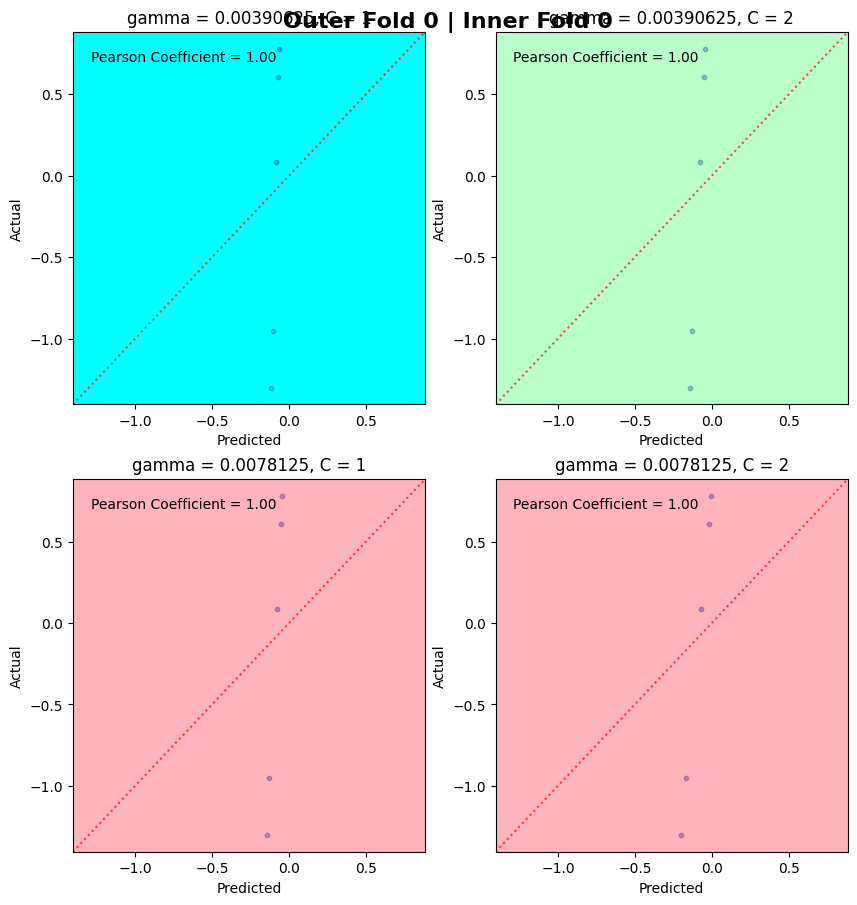

    INNER FOLD 1
    Best parameters found: 
param1    0.003906
param2           1
Name: 1, dtype: object


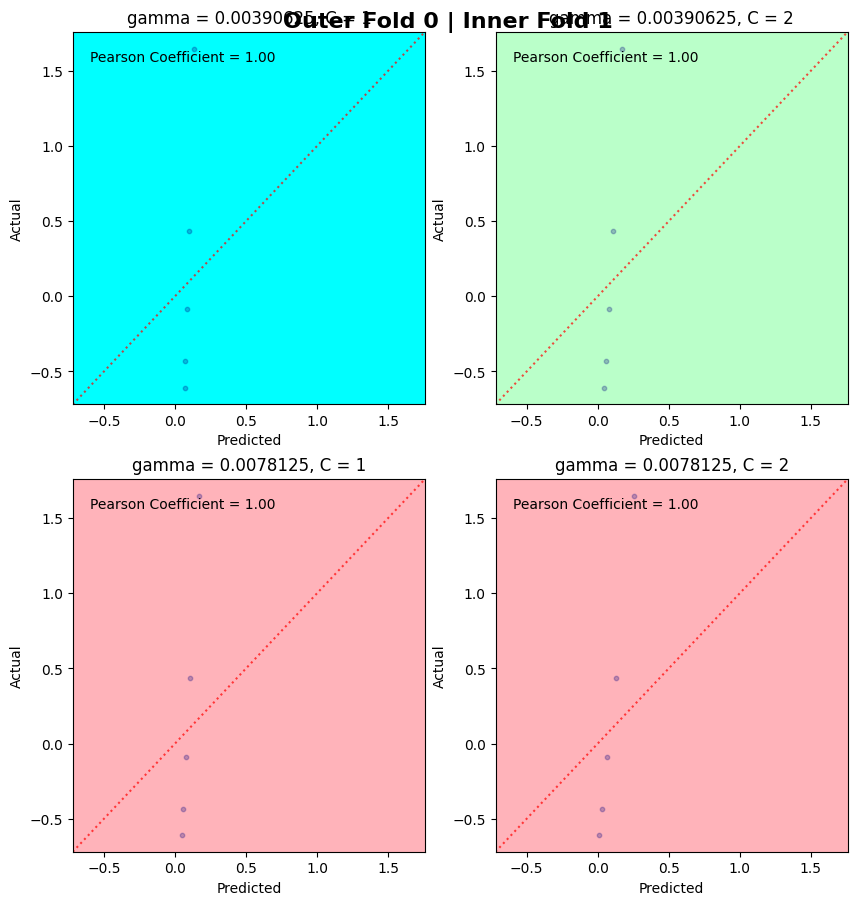

Average best parameters: 0.00390625, 1.0
Predictions: 
          GY
0  -0.085624
1  -0.076781
3  -0.058934
5  -0.040915
8  -0.013672
11  0.013675
15  0.050001
16  0.059016
17  0.067991
18  0.076920
Actuals: 
          GY
0  -1.647509
1  -1.474087
3  -1.127243
5  -0.780399
8  -0.260133
11  0.260133
15  0.953821
16  1.127243
17  1.300665
18  1.474087
Top Boundary Value: 
0.028205727062750777
Binary Predictions: 
       GY
0   False
1   False
3   False
5   False
8   False
11  False
15   True
16   True
17   True
18   True
Binary Actuals: 
       GY
0   False
1   False
3   False
5   False
8   False
11   True
15   True
16   True
17   True
18   True
OUTER CV: train_SVM_regressor, FOLD 1
    INNER FOLD 0
    Best parameters found: 
param1    0.003906
param2           1
Name: 0, dtype: object


C:\Users\kevin\AppData\Local\Temp\ipykernel_12284\4245451752.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)


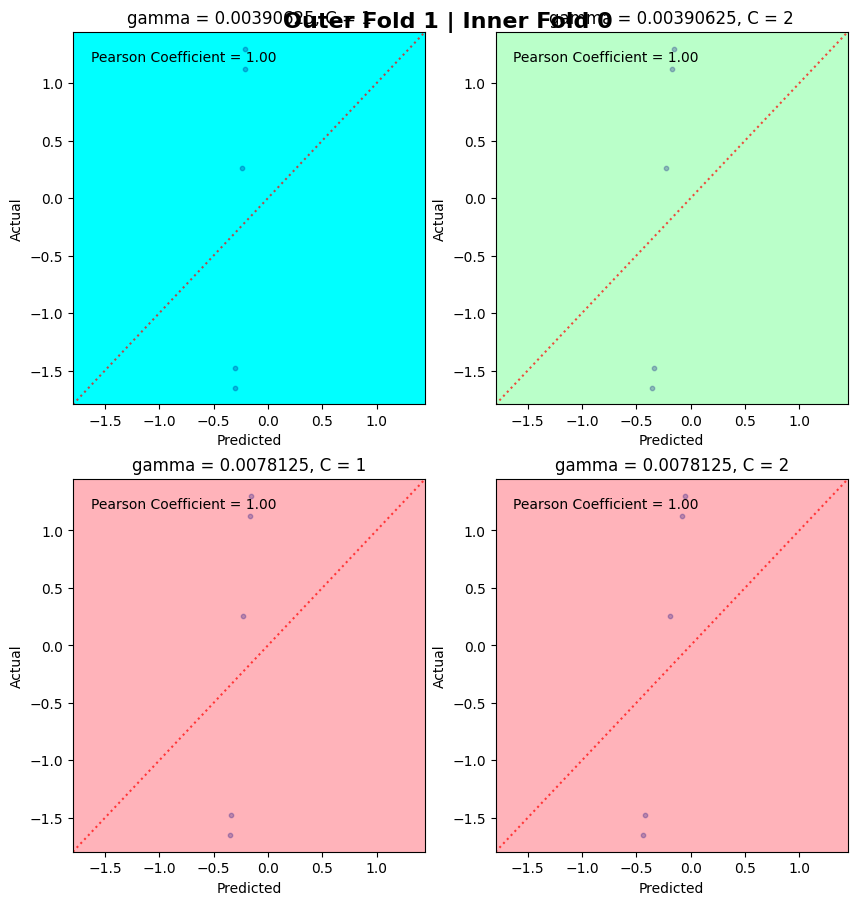

    INNER FOLD 1
    Best parameters found: 
param1    0.003906
param2           1
Name: 1, dtype: object


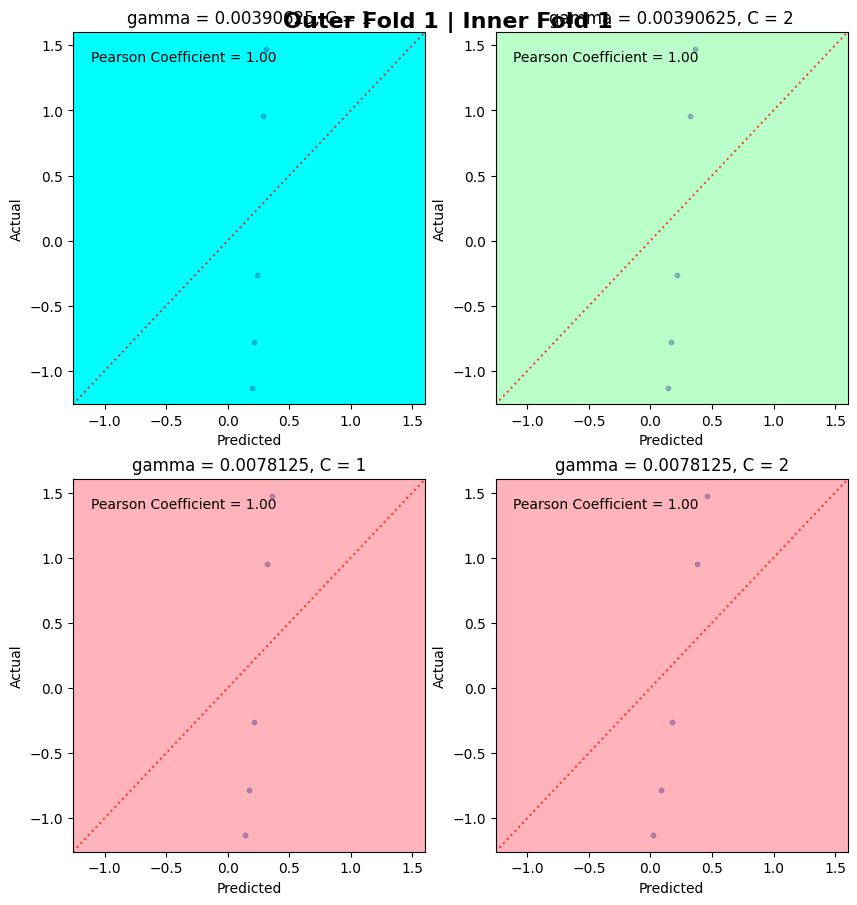

Average best parameters: 0.00390625, 1.0
Predictions: 
          GY
2  -0.104412
4  -0.076791
6  -0.048962
7  -0.034994
9  -0.007001
10  0.007005
12  0.034987
13  0.048943
14  0.062862
19  0.131579
Actuals: 
          GY
2  -1.300665
4  -0.953821
6  -0.606977
7  -0.433555
9  -0.086711
10  0.086711
12  0.433555
13  0.606977
14  0.780399
19  1.647509
Top Boundary Value: 
0.01819758250457882
Binary Predictions: 
       GY
2   False
4   False
6   False
7   False
9   False
10  False
12   True
13   True
14   True
19   True
Binary Actuals: 
       GY
2   False
4   False
6   False
7   False
9   False
10   True
12   True
13   True
14   True
19   True


In [13]:

# Real values 
x_params_SVM_R = mdo.AxisParams('gamma', bmo.power_list(2, -14, -6))
y_params_SVM_R = mdo.AxisParams('C', bmo.power_list(2, -2, 6))
metrics_SVM_R = outer_CV_R(5, 10, X_sc, y_sc, x_params_SVM_R, y_params_SVM_R, bmo.train_SVM_regressor, kfold_random_state=RANDOM_STATE, kernel='rbf', top_line_thresh=TOP_LINE_THRESH)

"""
# Dummy values for quick debugging tests
x_params_SVM_R = mdo.AxisParams('gamma', bmo.power_list(2, -8, -7))
y_params_SVM_R = mdo.AxisParams('C', bmo.power_list(2, 0, 1))
metrics_SVM_R = outer_CV_R(2, 2, X_sc, y_sc, x_params_SVM_R, y_params_SVM_R, bmo.train_SVM_regressor, kfold_random_state=RANDOM_STATE, kernel='rbf', top_line_thresh=TOP_LINE_THRESH)
"""

In [14]:
# Display classification metrics for best model from each outer fold
display(metrics_SVM_R)

,Pearson,F1 Score,Sensitivity,Specificity,Kappa,Precision
0,0.999996,0.888889,0.8,1.0,0.8,1.0
1,0.999993,0.888889,0.8,1.0,0.8,1.0


In [15]:
# Save average of each metric
metrics_SVM_R_mean = metrics_SVM_R.mean().to_frame().T
R_average_metrics.loc['SVM'] = metrics_SVM_R_mean.iloc[0]
display(metrics_SVM_R_mean)

,Pearson,F1 Score,Sensitivity,Specificity,Kappa,Precision
0,0.999994,0.888889,0.8,1.0,0.8,1.0


## XGBoost

OUTER CV: train_XGB_regressor, FOLD 0
    INNER FOLD 0
    Best parameters found: 
param1    2
param2    2
Name: 0, dtype: object


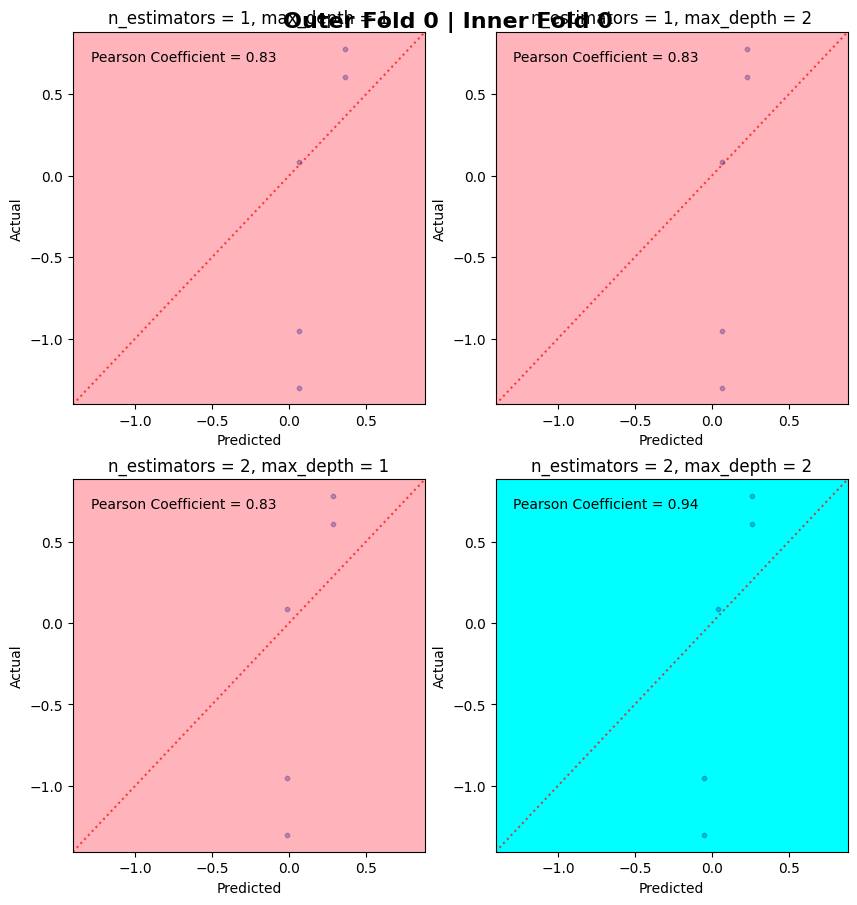

    INNER FOLD 1
    Best parameters found: 
param1    1
param2    2
Name: 1, dtype: object


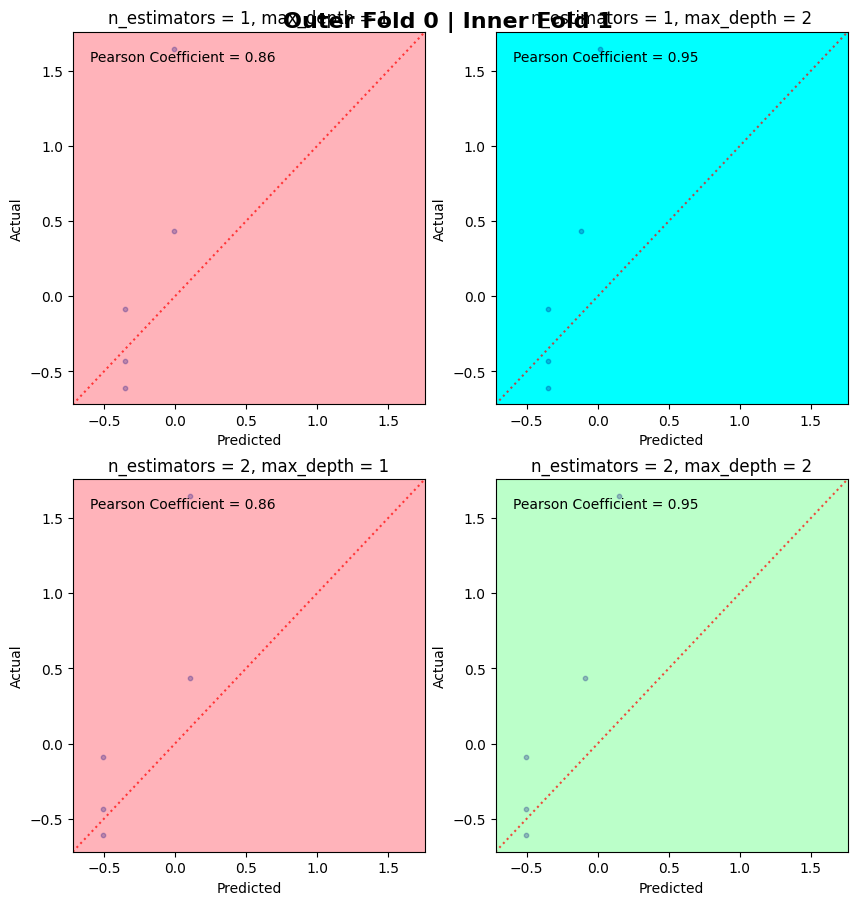

Average best parameters: 1.5, 2.0
Predictions: 
          GY
0  -0.357614
1  -0.357614
3  -0.357614
5  -0.357614
8  -0.218269
11  0.054871
15  0.399113
16  0.399113
17  0.399113
18  0.399113
Actuals: 
          GY
0  -1.647509
1  -1.474087
3  -1.127243
5  -0.780399
8  -0.260133
11  0.260133
15  0.953821
16  1.127243
17  1.300665
18  1.474087
Top Boundary Value: 
0.1925678014755247
Binary Predictions: 
       GY
0   False
1   False
3   False
5   False
8   False
11  False
15   True
16   True
17   True
18   True
Binary Actuals: 
       GY
0   False
1   False
3   False
5   False
8   False
11   True
15   True
16   True
17   True
18   True
OUTER CV: train_XGB_regressor, FOLD 1
    INNER FOLD 0
    Best parameters found: 
param1    1
param2    2
Name: 0, dtype: object


C:\Users\kevin\AppData\Local\Temp\ipykernel_12284\4245451752.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)


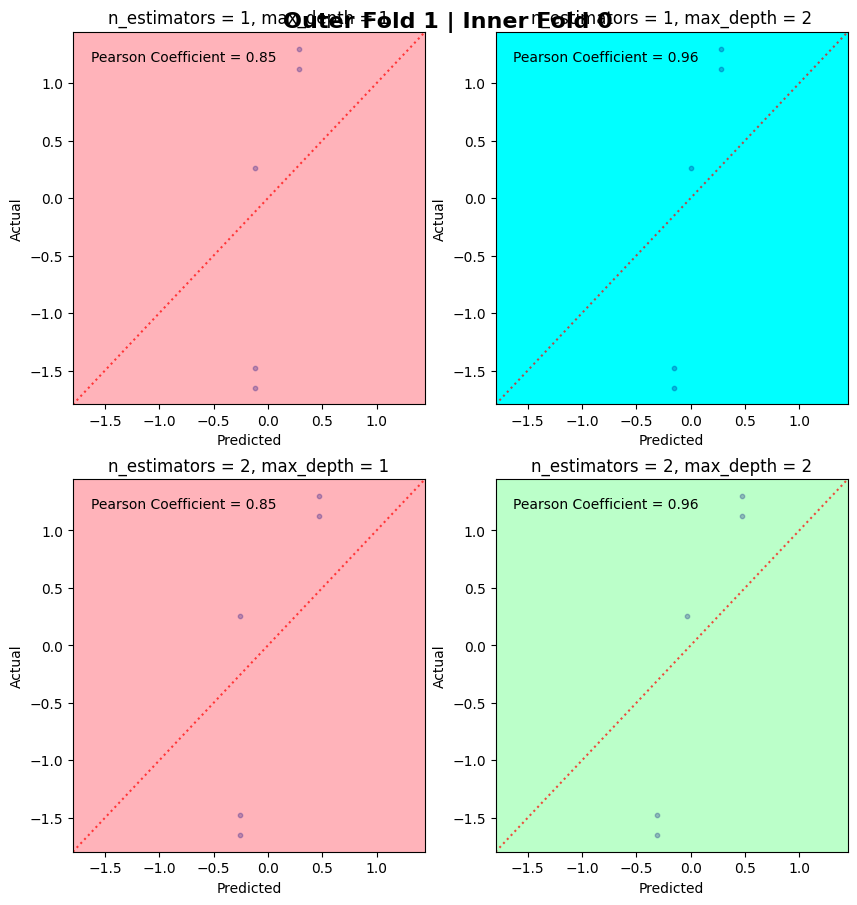

    INNER FOLD 1
    Best parameters found: 
param1    2
param2    2
Name: 1, dtype: object


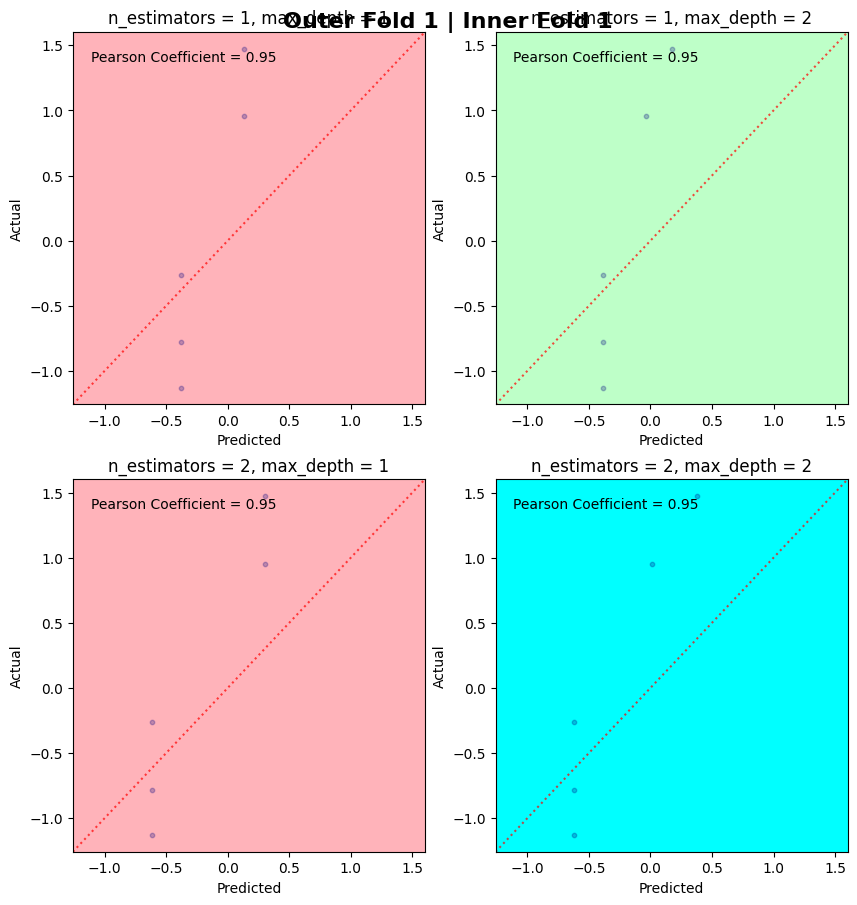

Average best parameters: 1.5, 2.0
Predictions: 
          GY
2  -0.562737
4  -0.562737
6  -0.382118
7  -0.382118
9  -0.120945
10 -0.120945
12  0.059657
13  0.059657
14  0.059657
19  0.502757
Actuals: 
          GY
2  -1.300665
4  -0.953821
6  -0.606977
7  -0.433555
9  -0.086711
10  0.086711
12  0.433555
13  0.606977
14  0.780399
19  1.647509
Top Boundary Value: 
-0.0487038403749467
Binary Predictions: 
       GY
2   False
4   False
6   False
7   False
9   False
10  False
12   True
13   True
14   True
19   True
Binary Actuals: 
       GY
2   False
4   False
6   False
7   False
9   False
10   True
12   True
13   True
14   True
19   True


In [16]:

# Test values
x_params_XGB_R = mdo.AxisParams('n_estimators', [13, 25, 50, 100, 200])
y_params_XGB_R = mdo.AxisParams('max_depth', [1, 2, 3, 4, 6, 10, 16])
metrics_XGB_R = outer_CV_R(5, 10, X_sc, y_sc, x_params_XGB_R, y_params_XGB_R, bmo.train_XGB_regressor, kfold_random_state=RANDOM_STATE, random_state=RANDOM_STATE, top_line_thresh=TOP_LINE_THRESH, objective="reg:squarederror", eval_metric="rmse")

"""
# Dummy values for quick debugging tests
x_params_XGB_R = mdo.AxisParams('n_estimators', [1, 2])
y_params_XGB_R = mdo.AxisParams('max_depth', [1, 2])
metrics_XGB_R = outer_CV_R(2, 2, X_sc, y_sc, x_params_XGB_R, y_params_XGB_R, bmo.train_XGB_regressor, kfold_random_state=RANDOM_STATE, random_state=RANDOM_STATE, objective="reg:squarederror", eval_metric="rmse", top_line_thresh=TOP_LINE_THRESH)
"""

In [17]:
# Display classification metrics for best model from each outer fold
display(metrics_XGB_R)

,Pearson,F1 Score,Sensitivity,Specificity,Kappa,Precision
0,0.966362,0.888889,0.8,1.0,0.8,1.0
1,0.986057,0.888889,0.8,1.0,0.8,1.0


In [18]:
# Print average of each metric and store results for analysis
metrics_XGB_R_mean = metrics_XGB_R.mean().to_frame().T
display(metrics_XGB_R_mean)
R_average_metrics.loc['XGB'] = metrics_XGB_R_mean.iloc[0]

,Pearson,F1 Score,Sensitivity,Specificity,Kappa,Precision
0,0.97621,0.888889,0.8,1.0,0.8,1.0


In [19]:
# Save serialized session variables and models to disk for later use
dill.dump_session(f'{storage_dir}\\project_ipynb_env_R.db')

# Model B

In [20]:
def inner_CV_B(n_splits: int, X : pd.DataFrame, y_bin : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback, kfold_random_state: int, classification_col : int, top_line_thresh : float, plot_title: str = "", **kwargs):
    """
    Perform inner cross-validation to tune model hyperparameters and find the optimal classification threshold.
    Created: 2024/12/04
    Parameters:
    n_splits (int): Number of splits for KFold cross-validation.
    X (pd.DataFrame): Feature data.
    y (pd.DataFrame): Target data.
    axis1_params (mdo.AxisParams): Object containing hyperparameter values for the first (horizontal) axis.
    axis2_params (mdo.AxisParams): Object containing hyperparameter values for the second (vertical) axis.
    train_model_callback (function): Callback function to train the model.
    kfold_random_state (int): Random state for KFold shuffling.
    classification_col (int): Column index to pull classification proabibilities from - 0 for not top, 1 for top.
    top_line_thresh (float): Threshold to classify predictions as top or not top.
    plot_title (str, optional): Title for the ROC plot. Defaults to "".
    **kwargs: Additional arguments for the train_model_callback function.
    Returns:
    tuple: Average best parameters (param1, param2) and the best classification threshold.
    """
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_random_state)

    # Arrays to store parameters and binary classification thresholds of most accurate model for each inner fold
    best_params = pd.DataFrame(columns=['param1', 'param2'], index=range(n_splits))
    best_thresholds = pd.DataFrame(columns=['threshold'], index=range(n_splits))

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        print(f"    INNER FOLD {i}")
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_bin_train, y_bin_test = y_bin.iloc[train_index], y_bin.iloc[test_index]
        
        # Train numpy 2D array of models with every combination of parameters
        model_grid = bmo.train_model_grid(X_train, y_bin_train, axis1_params, axis2_params, train_model_callback, **kwargs)
        
        # Use trained models to predict test set probabilities, and store in 2D array with each cell corresponding to a model with specific combination of parameters
        y_proba_preds_grid = bmo.grid_predict_proba(X_test, model_grid, classification_col)

        # Use probabilities to classify predictions as top or not top. This isn't the final classification, 
        # but a step towards finding the optimal threshold, so we just use the default 0.5 threshold for now.
        y_binary_preds_grid = bmo.continuous_to_binary_absolute_grid(y_proba_preds_grid, 0.5)

        # Create 2D array of identical dataframes containing actual labels to compare against predictions
        y_bin_test_grid = cdt.np_array_of_dfs(y_bin_test, y_proba_preds_grid.shape)

        # Evaluate predictions by comparing to actuals, calculating 2D array of f1 scores.
        f1_grid = bmo.calculate_f1_scores(y_binary_preds_grid, y_bin_test_grid)

        # Find index of best f1 score in the 2d array of f1 scores
        best_row, best_col = np.unravel_index(np.argmax(f1_grid), f1_grid.shape)
        print("     Best row, best col: \n", best_row, best_col)
        print("     Inner CV Probability Predictions at best row, best col: \n", y_proba_preds_grid[best_row, best_col])
        print("     Inner CV binary predictions at best row, best col: \n", y_binary_preds_grid[best_row, best_col])
        print("     Inner CV actuals at best row, best col: \n", y_bin_test_grid[best_row, best_col])
        print("     Inner CV f1 score at best row, best col: \n", f1_grid[best_row, best_col])

        # Store hyperparameters of most accurate model for this inner fold
        best_params.loc[i] = [axis1_params.values[best_row], axis2_params.values[best_col]]
        print(f"    Best parameters found: \n{best_params.loc[i]}")

        # Find classification probability threshold between zero and one that yields lowest squared difference between sensitivity and 
        # specificity using this optimal model. To do this, we feed find_optimal_threshold() the probabilities predicted by the model, not the binary predictions.
        best_model_proba_preds = y_proba_preds_grid[best_row, best_col]
        best_thresholds.iloc[i, 0] = bmo.find_optimal_threshold_absolute(y_bin_test, best_model_proba_preds)
        print(f"    Best probability threshold found: {best_thresholds.iloc[i, 0]}")

        # Create grid of ROC plots with predictions vs actuals, coloured by f1 score for each model
        roc_grid = plot_shaded_roc_grids(y_binary_preds_grid, y_bin_test_grid, axis1_params, axis2_params, f1_grid, plot_title, i)        
        plt.savefig(f'{storage_dir}\\model_B, {train_model_callback.__name__}, ({plot_title}, Inner Fold {i}).svg', format="svg")

        plt.show(roc_grid)
        plt.close(roc_grid)

    # Calculate average best parameters over all inner folds to return to outer CV
    avg_best_param1 = best_params['param1'].mean()
    avg_best_param2 = best_params['param2'].mean()

    # Calculate average best threshold over all folds
    best_threshold = best_thresholds['threshold'].mean()

    return avg_best_param1, avg_best_param2, best_threshold

        

In [21]:
def outer_CV_B(n_outer_splits: int, n_inner_splits: int, X : pd.DataFrame, y_cont : pd.DataFrame, axis1_params: mdo.AxisParams, 
               axis2_params: mdo.AxisParams, train_model_callback : callable, kfold_random_state: int, 
               classification_col : int, top_line_thresh : float, **kwargs) -> pd.DataFrame:
    """
    Perform nested cross-validation with an outer and inner loop to evaluate model B performance.
    Created: 2024/12/29
    Parameters:
    -----------
    n_outer_splits : int
        Number of splits for the outer cross-validation.
    n_inner_splits : int
        Number of splits for the inner cross-validation.
    X : pd.DataFrame
        Feature data.
    y : pd.DataFrame
        Target data.
    axis1_params : mdo.AxisParams
        Object representing hyperparameter search space for the first axis.
    axis2_params : mdo.AxisParams
        Object representing hyperparameter search space for the second axis.
    train_model_callback : callable
        Function to train the model.
    kfold_random_state : int
        Random state for reproducibility in KFold.
    classification_col : int
        Column index to pull classification probabilities from - 0 for not top, 1 for top.
    top_line_thresh : float
        Threshold to classify predictions as top or not top.
    **kwargs : dict
        Additional parameters for the model training function.
    Returns:
    --------
    pd.DataFrame
        DataFrame containing the metrics for each outer fold, including F1 Score, Sensitivity, Specificity, and Kappa.
    """

    y_binary = bmo.continuous_to_binary_quantile(y_cont, top_line_thresh)
    
    kfold = KFold(n_splits=n_outer_splits, shuffle=True, random_state=kfold_random_state)

    # Store metrics of best model for each fold
    kfold_metrics = pd.DataFrame(columns=['F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        print(f"OUTER CV: {train_model_callback.__name__}, FOLD {i}")

        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train_bin, y_test_bin = y_binary.iloc[train_index], y_binary.iloc[test_index]

        # Find average best parameters and threshold based on f1 score using inner-fold CV
        best_param1, best_param2, best_threshold = inner_CV_B(n_inner_splits, X_train, y_train_bin, axis1_params, axis2_params, train_model_callback, kfold_random_state, classification_col, top_line_thresh, plot_title=f"Outer Fold {i}", **kwargs)

        print(f"Average best parameters: {best_param1}, {best_param2}")
        print(f"Average best threshold: {best_threshold}")

        # Train model with all training and CV data of outer fold using mean best hyperparameters
        super_model = train_model_callback(X_train, np.ravel(y_train_bin), **dict(zip([axis1_params.name, axis2_params.name], [best_param1, best_param2])), **kwargs)

        # Use trained "super-model" to predict test set probabilities
        y_pred = pd.DataFrame(super_model.predict_proba(X_test)[:, classification_col], index=y_test_bin.index, columns=y_test_bin.columns)

        # Classify predictions and actuals of super_model as top or not top (boolean) using the best threshold as determined by inner CV
        y_pred_bin = bmo.continuous_to_binary_absolute(y_pred, best_threshold)
        print(f"Probability Predictions: \n{y_pred}")
        print(f"Binary Predictions: \n{y_pred_bin}")
        print(f"Actuals: \n{y_test_bin}")
    
        # Calculate classification metrics and add new row to kfold_metrics   
        classification_metrics = cdt.classification_metrics(y_pred_bin, y_test_bin)   
        kfold_metrics = pd.concat([kfold_metrics, classification_metrics], axis=0)   

    # Label each row of kfold_metrics with the fold number
    kfold_metrics.index = range(n_outer_splits)
    return kfold_metrics

## SVM

OUTER CV: train_SVM_classifier, FOLD 0
    INNER FOLD 0
     Best row, best col: 
 0 0
     Inner CV Probability Predictions at best row, best col: 
           0
0  0.752845
1  0.752031
2  0.749564
3  0.748321
4  0.747906
     Inner CV binary predictions at best row, best col: 
       0
0  True
1  True
2  True
3  True
4  True
     Inner CV actuals at best row, best col: 
        GY
2   False
4   False
10  False
13   True
14   True
     Inner CV f1 score at best row, best col: 
 0.5714285714285714
    Best parameters found: 
param1    0.000977
param2           1
Name: 0, dtype: object
    Best probability threshold found: 0.7495639432221126


c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.le

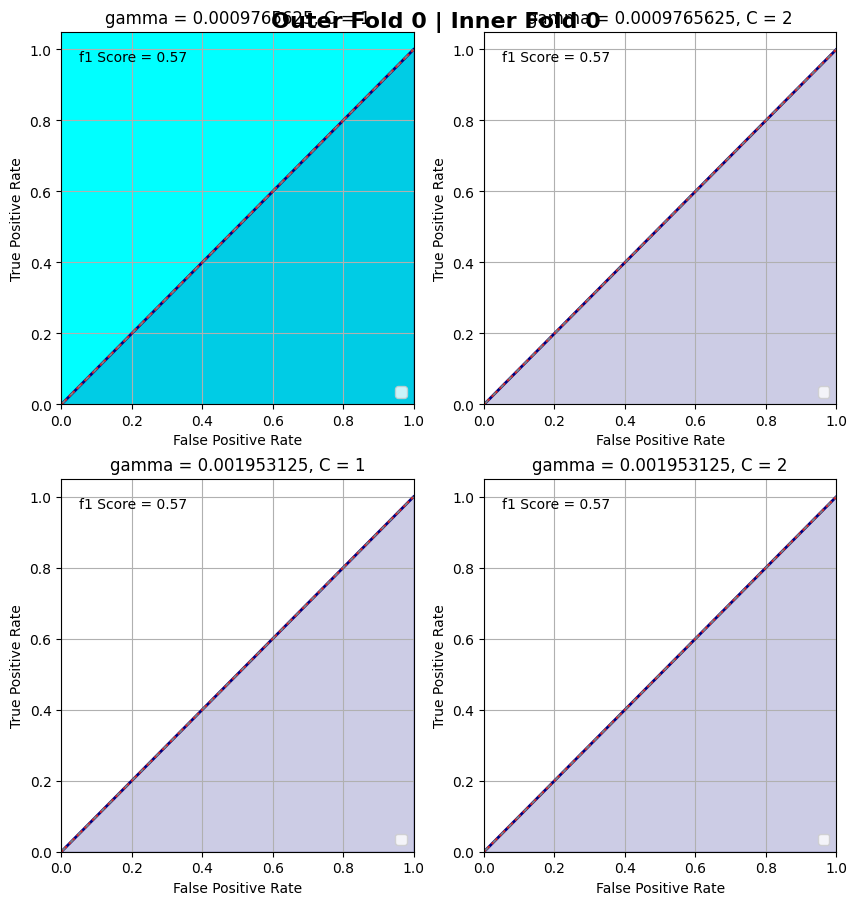

    INNER FOLD 1
     Best row, best col: 
 0 0
     Inner CV Probability Predictions at best row, best col: 
           0
0  0.749547
1  0.749190
2  0.748474
3  0.747398
4  0.744883
     Inner CV binary predictions at best row, best col: 
       0
0  True
1  True
2  True
3  True
4  True
     Inner CV actuals at best row, best col: 
        GY
6   False
7   False
9   False
12   True
19   True
     Inner CV f1 score at best row, best col: 
 0.5714285714285714
    Best parameters found: 
param1    0.000977
param2           1
Name: 1, dtype: object
    Best probability threshold found: 0.7484738590540494


c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.le

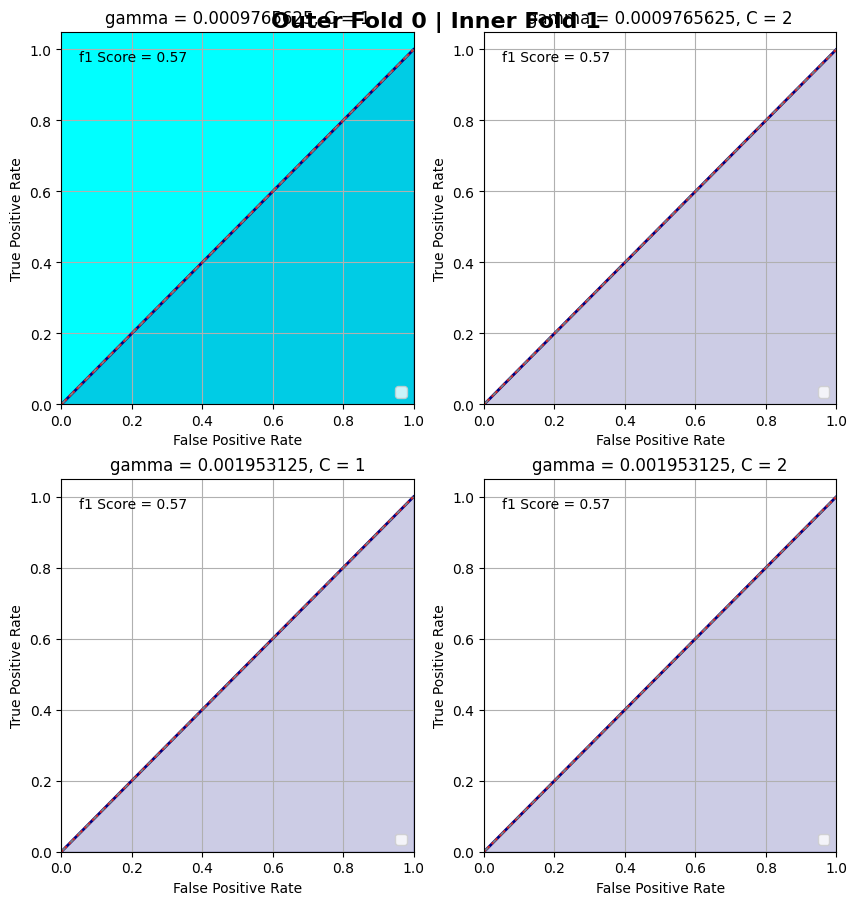

Average best parameters: 0.0009765625, 1.0
Average best threshold: 0.749018901138081
Probability Predictions: 
          GY
0   0.603954
1   0.603073
3   0.601306
5   0.599534
8   0.596870
11  0.594201
15  0.590644
16  0.589756
17  0.588869
18  0.587983
Binary Predictions: 
       GY
0   False
1   False
3   False
5   False
8   False
11  False
15  False
16  False
17  False
18  False
Actuals: 
       GY
0   False
1   False
3   False
5   False
8   False
11  False
15   True
16   True
17   True
18   True
OUTER CV: train_SVM_classifier, FOLD 1
    INNER FOLD 0
     Best row, best col: 
 0 0
     Inner CV Probability Predictions at best row, best col: 
           0
0  0.754458
1  0.753917
2  0.748418
3  0.745630
4  0.745071
     Inner CV binary predictions at best row, best col: 
       0
0  True
1  True
2  True
3  True
4  True
     Inner CV actuals at best row, best col: 
        GY
0   False
1   False
11  False
16   True
17   True
     Inner CV f1 score at best row, best col: 
 0.5714285714

c:\Users\kevin\dev\ml_research\custom_dataset_tools.py:38: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\kevin\AppData\Local\Temp\ipykernel_12284\799251774.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kfold_metrics = pd.concat([kfold_metrics, classification_metrics], axis=0)
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an

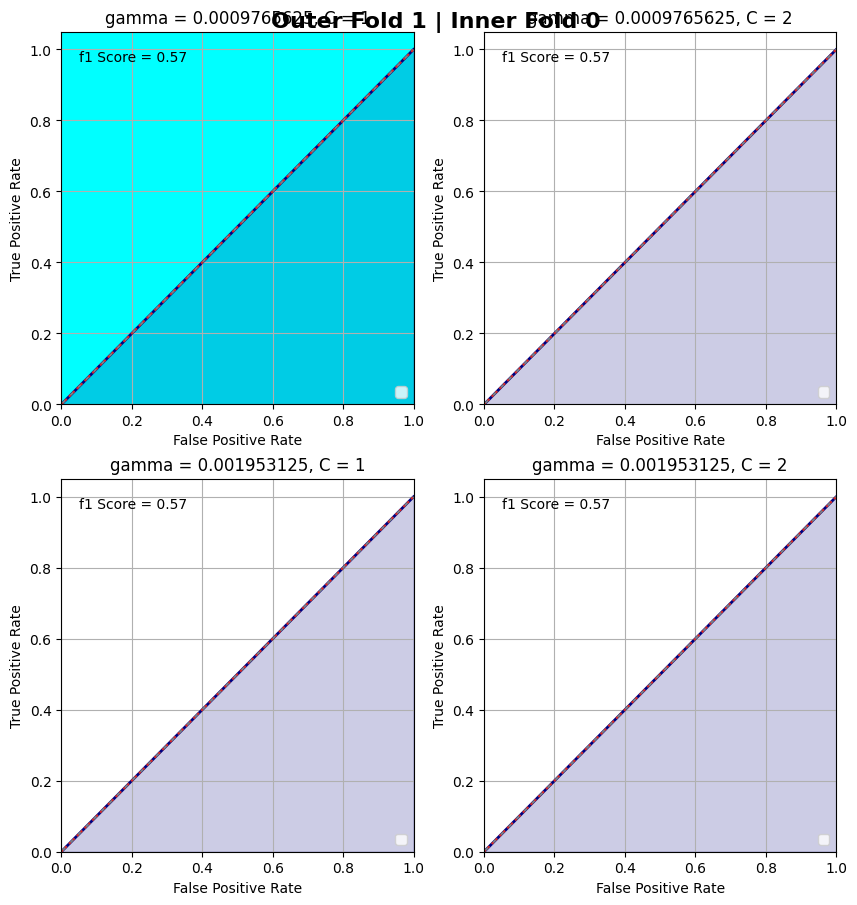

    INNER FOLD 1
     Best row, best col: 
 0 0
     Inner CV Probability Predictions at best row, best col: 
           0
0  0.750118
1  0.748963
2  0.747220
3  0.743119
4  0.741353
     Inner CV binary predictions at best row, best col: 
       0
0  True
1  True
2  True
3  True
4  True
     Inner CV actuals at best row, best col: 
        GY
3   False
5   False
8   False
15   True
18   True
     Inner CV f1 score at best row, best col: 
 0.5714285714285714
    Best parameters found: 
param1    0.000977
param2           1
Name: 1, dtype: object
    Best probability threshold found: 0.7472196710160294


c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.le

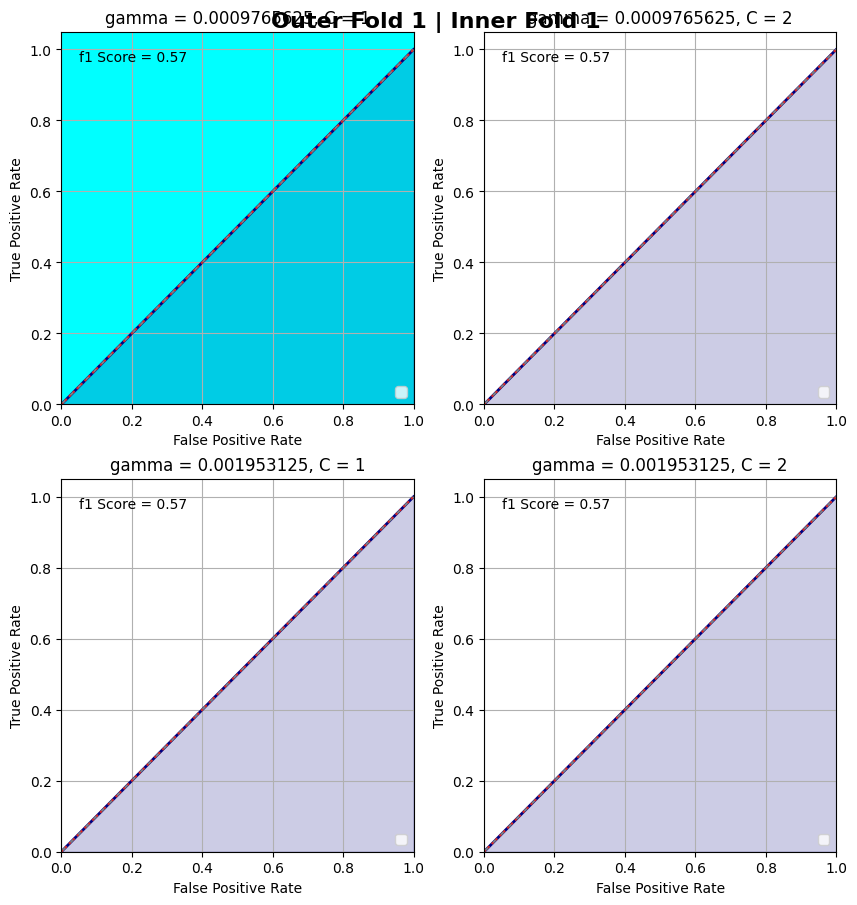

Average best parameters: 0.0009765625, 1.0
Average best threshold: 0.7478188646335179
Probability Predictions: 
          GY
2   0.600997
4   0.598349
6   0.595696
7   0.594368
9   0.591710
10  0.590381
12  0.587722
13  0.586392
14  0.585064
19  0.578436
Binary Predictions: 
       GY
2   False
4   False
6   False
7   False
9   False
10  False
12  False
13  False
14  False
19  False
Actuals: 
       GY
2   False
4   False
6   False
7   False
9   False
10  False
12   True
13   True
14   True
19   True


c:\Users\kevin\dev\ml_research\custom_dataset_tools.py:38: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [22]:

# Real test values
x_params_SVM_B = mdo.AxisParams('gamma', bmo.power_list(2, -18, -8))
y_params_SVM_B = mdo.AxisParams('C', bmo.power_list(2, 2, 16))
metrics_SVM_B = outer_CV_B(5, 10, X_sc, y_sc, x_params_SVM_B, y_params_SVM_B, bmo.train_SVM_classifier, kfold_random_state=RANDOM_STATE, kernel='rbf', classification_col=1, top_line_thresh=TOP_LINE_THRESH, probability=True)

"""
# Dummy values for tests
x_params_SVM_B = mdo.AxisParams('gamma', bmo.power_list(2, -10, -9))
y_params_SVM_B = mdo.AxisParams('C', bmo.power_list(2, 0, 1))
metrics_SVM_B = outer_CV_B(2, 2, X_sc, y_sc, x_params_SVM_B, y_params_SVM_B, bmo.train_SVM_classifier, kfold_random_state=RANDOM_STATE, kernel='rbf', classification_col=1, top_line_thresh=TOP_LINE_THRESH, probability=True)
"""

In [23]:
# Display classification metrics for super-model trained on all data from each outer fold
display(metrics_SVM_B)

,F1 Score,Sensitivity,Specificity,Kappa,Precision
0,0.0,0.0,1.0,0.0,NaN
1,0.0,0.0,1.0,0.0,NaN


In [24]:
# Print average of each metric
metrics_SVM_B_mean = metrics_SVM_B.mean().to_frame().T
B_average_metrics.loc['SVM'] = metrics_SVM_B_mean.iloc[0]
display(metrics_SVM_B_mean)

,F1 Score,Sensitivity,Specificity,Kappa,Precision
0,0.0,0.0,1.0,0.0,NaN


## XGBoost

OUTER CV: train_XGB_classifier, FOLD 0
    INNER FOLD 0
     Best row, best col: 
 0 0
     Inner CV Probability Predictions at best row, best col: 
           0
0  0.401098
1  0.401098
2  0.401098
3  0.401098
4  0.401098
     Inner CV binary predictions at best row, best col: 
        0
0  False
1  False
2  False
3  False
4  False
     Inner CV actuals at best row, best col: 
        GY
2   False
4   False
10  False
13   True
14   True
     Inner CV f1 score at best row, best col: 
 0.0
    Best parameters found: 
param1    1
param2    1
Name: 0, dtype: object
    Best probability threshold found: 0.40109750628471375


c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.le

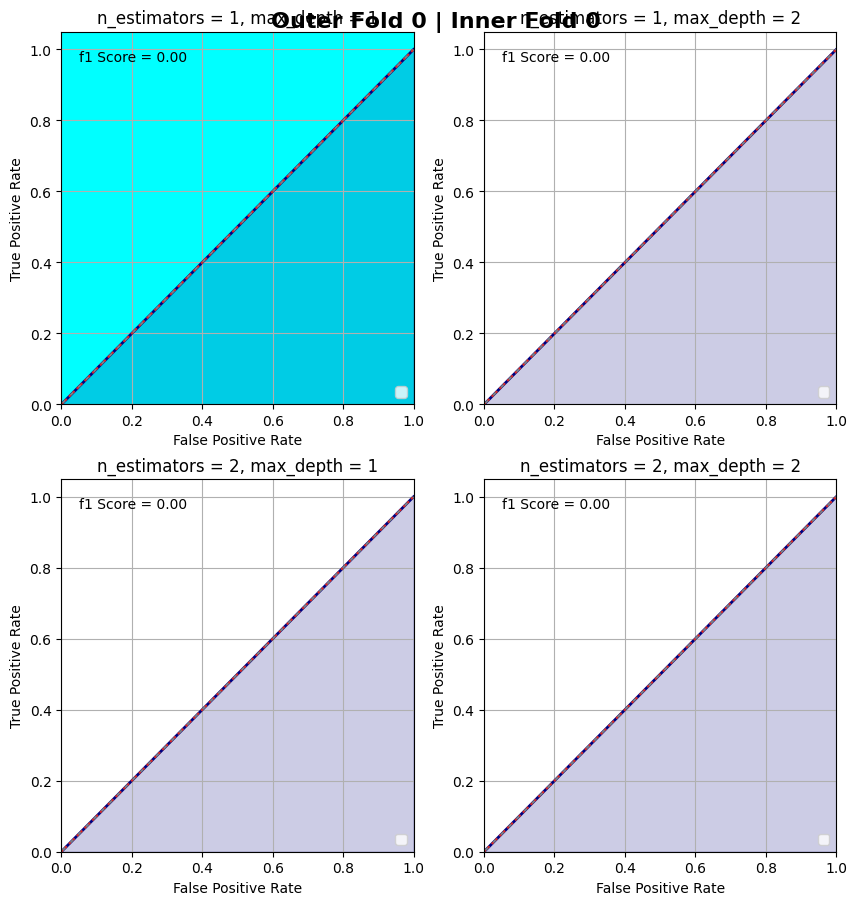

    INNER FOLD 1
     Best row, best col: 
 0 0
     Inner CV Probability Predictions at best row, best col: 
           0
0  0.401098
1  0.401098
2  0.401098
3  0.401098
4  0.401098
     Inner CV binary predictions at best row, best col: 
        0
0  False
1  False
2  False
3  False
4  False
     Inner CV actuals at best row, best col: 
        GY
6   False
7   False
9   False
12   True
19   True
     Inner CV f1 score at best row, best col: 
 0.0
    Best parameters found: 
param1    1
param2    1
Name: 1, dtype: object
    Best probability threshold found: 0.40109750628471375


c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.le

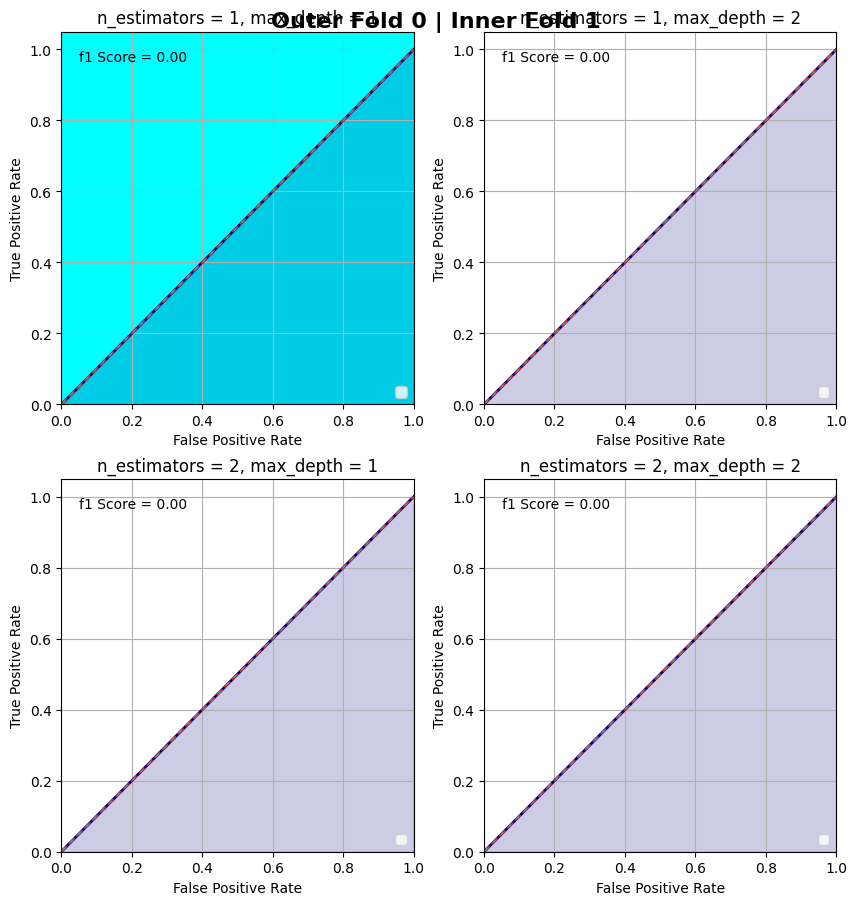

Average best parameters: 1.0, 1.0
Average best threshold: 0.40109750628471375
Probability Predictions: 
          GY
0   0.337723
1   0.337723
3   0.337723
5   0.337723
8   0.337723
11  0.467962
15  0.467962
16  0.467962
17  0.467962
18  0.467962
Binary Predictions: 
       GY
0   False
1   False
3   False
5   False
8   False
11   True
15   True
16   True
17   True
18   True
Actuals: 
       GY
0   False
1   False
3   False
5   False
8   False
11  False
15   True
16   True
17   True
18   True
OUTER CV: train_XGB_classifier, FOLD 1
    INNER FOLD 0
     Best row, best col: 
 0 0
     Inner CV Probability Predictions at best row, best col: 
           0
0  0.401098
1  0.401098
2  0.401098
3  0.401098
4  0.401098
     Inner CV binary predictions at best row, best col: 
        0
0  False
1  False
2  False
3  False
4  False
     Inner CV actuals at best row, best col: 
        GY
0   False
1   False
11  False
16   True
17   True
     Inner CV f1 score at best row, best col: 
 0.0
    Best 

C:\Users\kevin\AppData\Local\Temp\ipykernel_12284\799251774.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kfold_metrics = pd.concat([kfold_metrics, classification_metrics], axis=0)
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:

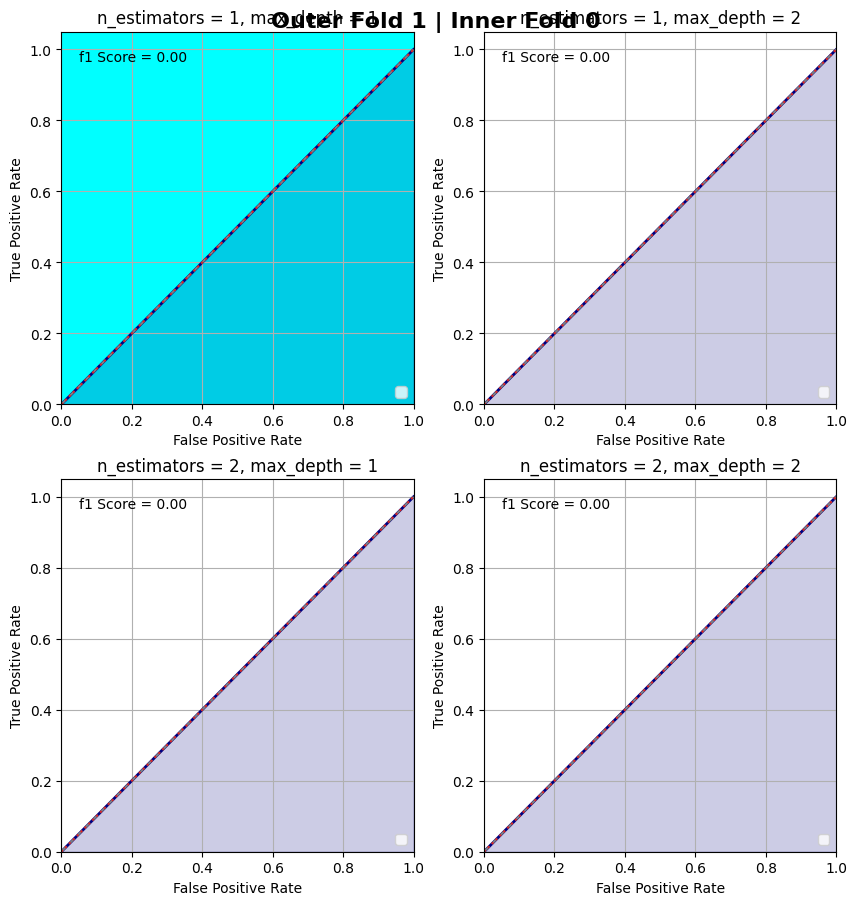

    INNER FOLD 1
     Best row, best col: 
 0 0
     Inner CV Probability Predictions at best row, best col: 
           0
0  0.401098
1  0.401098
2  0.401098
3  0.401098
4  0.401098
     Inner CV binary predictions at best row, best col: 
        0
0  False
1  False
2  False
3  False
4  False
     Inner CV actuals at best row, best col: 
        GY
3   False
5   False
8   False
15   True
18   True
     Inner CV f1 score at best row, best col: 
 0.0
    Best parameters found: 
param1    1
param2    1
Name: 1, dtype: object
    Best probability threshold found: 0.40109750628471375


c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\kevin\dev\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.le

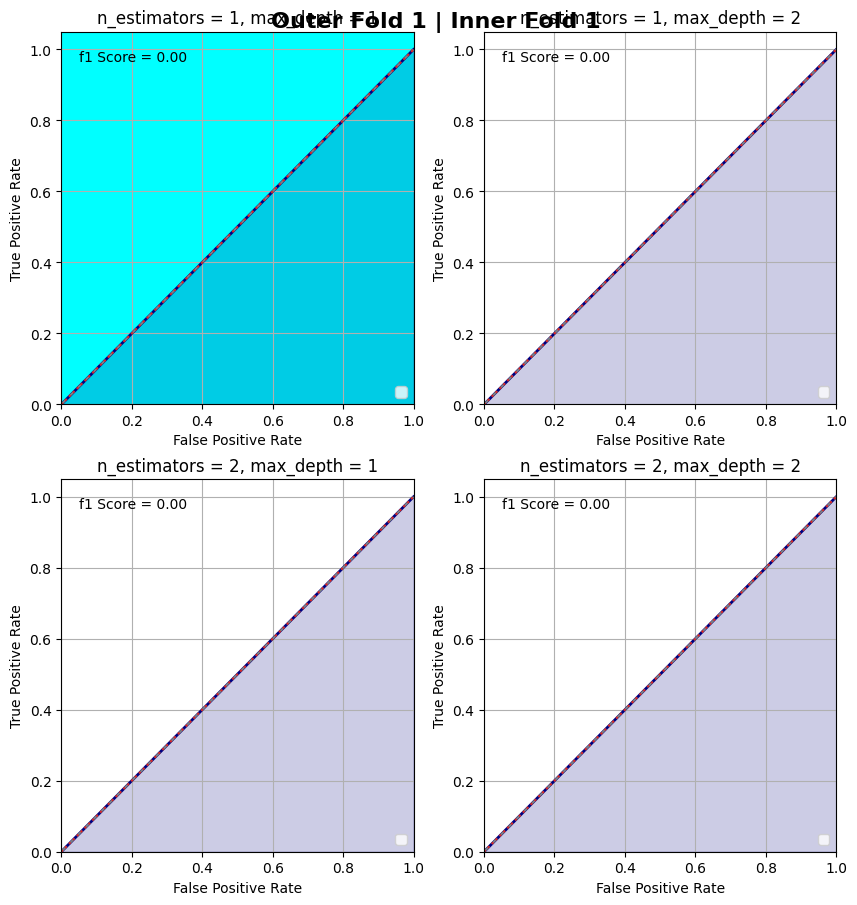

Average best parameters: 1.0, 1.0
Average best threshold: 0.40109750628471375
Probability Predictions: 
          GY
2   0.337723
4   0.337723
6   0.337723
7   0.337723
9   0.337723
10  0.337723
12  0.467962
13  0.467962
14  0.467962
19  0.467962
Binary Predictions: 
       GY
2   False
4   False
6   False
7   False
9   False
10  False
12   True
13   True
14   True
19   True
Actuals: 
       GY
2   False
4   False
6   False
7   False
9   False
10  False
12   True
13   True
14   True
19   True


In [25]:
# Real test values
x_params_XGB_B = mdo.AxisParams('n_estimators', [3, 7, 13, 25, 50, 100, 200, 400])
y_params_XGB_B = mdo.AxisParams('max_depth', [1, 2, 3, 4, 6, 10, 16, 32, 64])
metrics_XGB_B = outer_CV_B(5, 10, X_sc, y_sc, x_params_XGB_B, y_params_XGB_B, bmo.train_XGB_classifier, kfold_random_state=RANDOM_STATE, random_state=RANDOM_STATE, classification_col=1, top_line_thresh=TOP_LINE_THRESH, objective="binary:logistic", eval_metric="logloss")

"""
# dummy values for quick tests
x_params_XGB_B = mdo.AxisParams('n_estimators', [1, 2])
y_params_XGB_B = mdo.AxisParams('max_depth', [1, 2])
metrics_XGB_B = outer_CV_B(2, 2, X_sc, y_sc, x_params_XGB_B, y_params_XGB_B, bmo.train_XGB_classifier, kfold_random_state=RANDOM_STATE, random_state=RANDOM_STATE, classification_col=1, top_line_thresh=TOP_LINE_THRESH, objective="binary:logistic", eval_metric="logloss")
"""

In [26]:
# display metrics
display(metrics_XGB_B)

,F1 Score,Sensitivity,Specificity,Kappa,Precision
0,0.888889,1.0,0.833333,0.8,0.8
1,1.000000,1.0,1.000000,1.0,1.0


In [27]:
# Print average of each metric
metrics_XGB_B_mean = metrics_XGB_B.mean().to_frame().T
B_average_metrics.loc['XGB'] = metrics_XGB_B_mean.iloc[0]
display(metrics_XGB_B_mean)

,F1 Score,Sensitivity,Specificity,Kappa,Precision
0,0.944444,1.0,0.916667,0.9,0.9


In [28]:
# Save serialized session variables and models to disk for later use
dill.dump_session(f'{storage_dir}\\project_ipynb_env_B.db')

# Model RO

In [29]:
def inner_CV_RO(n_splits: int, X : pd.DataFrame, y : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback, 
                kfold_random_state: int, top_line_threshold: float, plot_title: str = "", **kwargs):
    
    """
    Perform inner cross-validation (RO) to find the best model parameters and classification threshold.
    Created: 2024/12/21
    Parameters:
    n_splits (int): Number of splits for K-Fold cross-validation.
    X (pd.DataFrame): Feature data.
    y (pd.DataFrame): Target data.
    axis1_params (mdo.AxisParams): Hyperparameters to explore for the horizontal axis.
    axis2_params (mdo.AxisParams): Hyperparameters to explore for the vertical axis.
    train_model_callback (callable): Callback function to train the model.
    kfold_random_state (int): Random state for K-Fold shuffling.
    top_line_threshold (float): Threshold to classify top values during intermediate step in inner CV.
    plot_title (str, optional): Title for the plot. Defaults to "".
    **kwargs: Additional keyword arguments for the model training callback.
    Returns:
    tuple: Average best parameters for axis1 and axis2, and the best classification threshold.
    """

    # Create KFold object for inner-fold cross-validation
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_random_state)

    # Store best parameters (param1, param2) for each fold
    best_params = pd.DataFrame(columns=['param1', 'param2'], index=range(n_splits))
    best_thresholds = pd.DataFrame(columns=['threshold'], index=range(n_splits))

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        print(f"    INNER FOLD {i}")
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train numpy 2D array of models with every combination of parameters
        model_grid = bmo.train_model_grid(X_train, y_train, axis1_params, axis2_params, train_model_callback, **kwargs)

        # Use trained models to predict test set labels, and store in 2D array with each cell corresponding to a model with specific combination of parameters
        y_preds_grid = bmo.grid_predict(X_test, model_grid)

        # Create 2D array of identical dataframes containing actual labels to compare against predictions
        y_test_grid = cdt.np_array_of_dfs(y_test, y_preds_grid.shape)

        # Evaluate predictions by comparing to actuals, calculating 2D array of pearson coefficients
        pearson_grid = bmo.calculate_pearson_coefficients(y_preds_grid, y_test_grid)

        # Find index of best pearson coefficient in the 2d array of pearson coefficients
        best_row, best_col = np.unravel_index(np.argmax(pearson_grid), pearson_grid.shape)
        
        # Store hyperparameters of most accurate model for this inner fold
        best_params.loc[i] = [axis1_params.values[best_row], axis2_params.values[best_col]]
        print(f"    Best parameters found: \n{best_params.loc[i]}")

        # Extract best model's continuous predictions
        best_model_y_preds = y_preds_grid[best_row, best_col]

        # Classify labels as top or not top (boolean)
        seperation_val = y_test.iloc[:, 0].quantile(top_line_threshold)
        y_test_binary = bmo.continuous_to_binary_absolute(y_test, seperation_val)
        print(f"    Predictions: \n{best_model_y_preds}")
        print(f"    Actuals: \n{y_test}")
        print(f"    Top Boundary Value (Calculated from Actuals): {seperation_val}")
        print(f"    Binary Actuals: \n{y_test_binary}")
        
        # Find classification threshold that yields lowest squared difference between sensitivity and specificity using this optimal model
        best_absolute_thresh = bmo.find_optimal_threshold_absolute(y_test_binary, best_model_y_preds)
        best_thresholds.iloc[i, 0] = best_absolute_thresh
        print(f"    Best threshold found: {best_absolute_thresh}")

        # Create grid of scatter plots with predictions vs actuals, coloured by pearson coefficient for each model
        scatter_grid = plot_shaded_scatter_grids(y_preds_grid, y_test_grid, axis1_params, axis2_params, pearson_grid, plot_title, i)        
        plt.savefig(f'{storage_dir}\\model_RO, {train_model_callback.__name__}, ({plot_title}, Inner Fold {i}).svg', format="svg")
        plt.show(scatter_grid)
        plt.close(scatter_grid)

    # Calculate average best parameters over all folds
    avg_best_param1 = best_params['param1'].mean()
    avg_best_param2 = best_params['param2'].mean()

    # Calculate average best threshold over all folds
    best_threshold = best_thresholds['threshold'].mean()

    return avg_best_param1, avg_best_param2, best_threshold

        

In [34]:
def outer_CV_RO(n_outer_splits: int, n_inner_splits: int, X : pd.DataFrame, y : pd.DataFrame, axis1_params: mdo.AxisParams, 
                axis2_params: mdo.AxisParams, train_model_callback : callable, kfold_random_state: int, top_line_threshold : float, 
                **kwargs) -> pd.DataFrame:
    """
    Perform outer cross-validation with nested inner cross-validation for model RO selection and evaluation.
    Parameters:
    -----------
    n_outer_splits : int
        Number of splits for the outer cross-validation.
    n_inner_splits : int
        Number of splits for the inner cross-validation.
    X : pd.DataFrame
        Feature data.
    y : pd.DataFrame
        Target data.
    axis1_params : mdo.AxisParams
        Object representing hyperparameter search space for the first axis.
    axis2_params : mdo.AxisParams
        Object representing hyperparameter search space for the second axis.
    train_model_callback : callable
        Callback function to train the model.
    kfold_random_state : int
        Random state for reproducibility in KFold splitting.
    top_line_threshold : float
        Threshold for classifying top predictions during intermediate step in inner CV.
    **kwargs : dict
        Additional parameters for the model training callback.
    Returns:
    --------
    pd.DataFrame
        DataFrame containing the evaluation metrics for each outer fold, including Pearson correlation, F1 Score, Sensitivity, Specificity, and Kappa.
    """

    # Create KFold object for outer loop to split data into train and test sets
    kfold = KFold(n_splits=n_outer_splits, shuffle=True, random_state=kfold_random_state)

    kfold_metrics = pd.DataFrame(columns=['Pearson', 'F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        print(f"OUTER CV: {train_model_callback.__name__}, FOLD {i}")

        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Find average best parameters and threshold based on pearson score using inner-fold CV
        best_param1, best_param2, best_threshold = inner_CV_RO(n_inner_splits, X_train, y_train, axis1_params, axis2_params, train_model_callback, kfold_random_state, top_line_threshold=top_line_threshold, plot_title=f"Outer Fold {i}", **kwargs)
        print(f"Average best parameters: {best_param1}, {best_param2}")
        print(f"Average best threshold: {best_threshold}")

        # Train model with all training and CV data of outer fold using mean best hyperparameters
        super_model = train_model_callback(X_train, np.ravel(y_train), **dict(zip([axis1_params.name, axis2_params.name], [best_param1, best_param2])), **kwargs)

        # Use trained "super-model" to predict test set
        y_pred = pd.DataFrame(super_model.predict(X_test), index=y_test.index, columns=y_test.columns)
        print(f"Super model predictions: \n{y_pred}")

        # Calculate pearson coefficient of continuous predictions
        pearson, _ = pearsonr(np.ravel(y_pred), np.ravel(y_test))

        # Classify predictions and actuals of super_model as top or not top (boolean)
        y_pred_top = bmo.continuous_to_binary_absolute(y_pred, best_threshold)
        y_test_top = bmo.continuous_to_binary_quantile(y_test, top_line_threshold)

        print(y_test_top)

        # Calculate classification metrics and add new row to kfold_metrics
        classification_metrics = cdt.classification_metrics(y_pred_top, y_test_top)
        pearson_df = pd.DataFrame([pearson], columns=['Pearson'])
        metrics_row = pd.concat([pearson_df, classification_metrics], axis=1)
        kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)
    
    kfold_metrics.index = range(n_outer_splits)
    return kfold_metrics

## SVM

OUTER CV: train_SVM_regressor, FOLD 0
    INNER FOLD 0
    Best parameters found: 
param1    0.003906
param2           1
Name: 0, dtype: object
    Predictions: 
          0
0 -0.115752
1 -0.107552
2 -0.082507
3 -0.069879
4 -0.065673
    Actuals: 
          GY
2  -1.300665
4  -0.953821
10  0.086711
13  0.606977
14  0.780399
    Top Boundary Value (Calculated from Actuals): 0.2948173896382007
    Binary Actuals: 
       GY
2   False
4   False
10  False
13   True
14   True
    Best threshold found: -0.06987888214023427


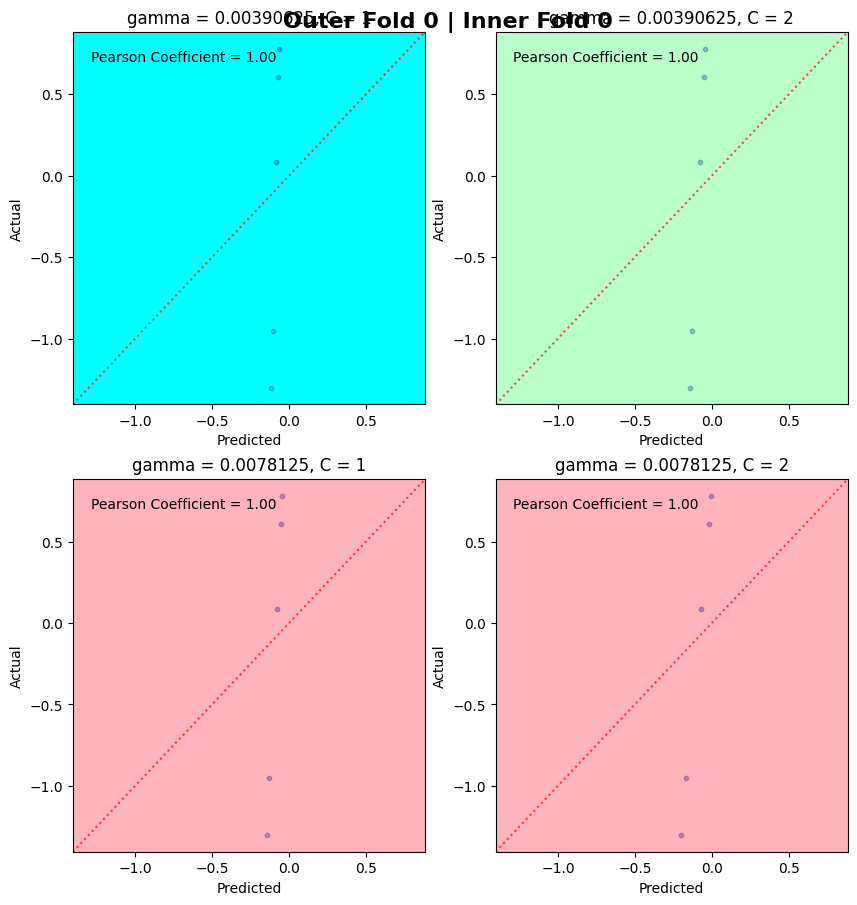

    INNER FOLD 1
    Best parameters found: 
param1    0.003906
param2           1
Name: 1, dtype: object
    Predictions: 
          0
0  0.067052
1  0.071964
2  0.081797
3  0.096517
4  0.130251
    Actuals: 
          GY
6  -0.606977
7  -0.433555
9  -0.086711
12  0.433555
19  1.647509
    Top Boundary Value (Calculated from Actuals): 0.12139539573337674
    Binary Actuals: 
       GY
6   False
7   False
9   False
12   True
19   True
    Best threshold found: 0.09651744286818195


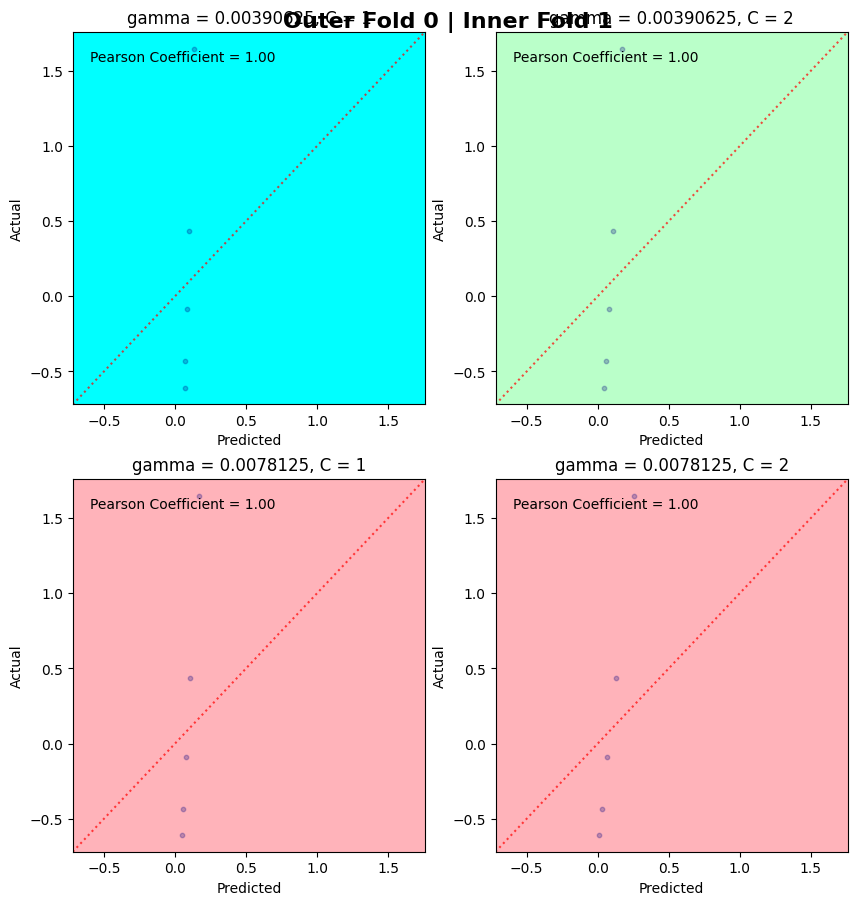

Average best parameters: 0.00390625, 1.0
Average best threshold: 0.01331928036397384
Super model predictions: 
          GY
0  -0.085624
1  -0.076781
3  -0.058934
5  -0.040915
8  -0.013672
11  0.013675
15  0.050001
16  0.059016
17  0.067991
18  0.076920
       GY
0   False
1   False
3   False
5   False
8   False
11  False
15   True
16   True
17   True
18   True
OUTER CV: train_SVM_regressor, FOLD 1
    INNER FOLD 0
    Best parameters found: 
param1    0.003906
param2           1
Name: 0, dtype: object
    Predictions: 
          0
0 -0.306149
1 -0.300501
2 -0.242610
3 -0.213517
4 -0.207752
    Actuals: 
          GY
0  -1.647509
1  -1.474087
11  0.260133
16  1.127243
17  1.300665
    Top Boundary Value (Calculated from Actuals): 0.6069769786668838
    Binary Actuals: 
       GY
0   False
1   False
11  False
16   True
17   True
    Best threshold found: -0.21351720894022597


C:\Users\kevin\AppData\Local\Temp\ipykernel_12284\3809933011.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)


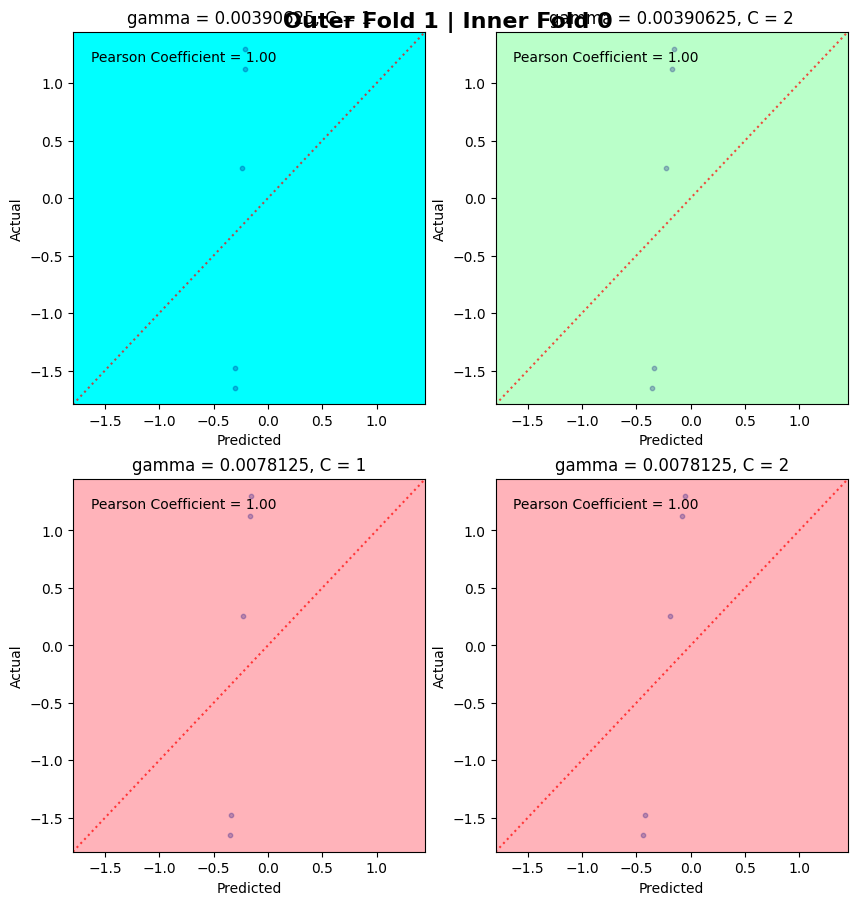

    INNER FOLD 1
    Best parameters found: 
param1    0.003906
param2           1
Name: 1, dtype: object
    Predictions: 
          0
0  0.200597
1  0.215413
2  0.237761
3  0.289755
4  0.311636
    Actuals: 
          GY
3  -1.127243
5  -0.780399
8  -0.260133
15  0.953821
18  1.474087
    Top Boundary Value (Calculated from Actuals): 0.2254485920762711
    Binary Actuals: 
       GY
3   False
5   False
8   False
15   True
18   True
    Best threshold found: 0.28975496981661775


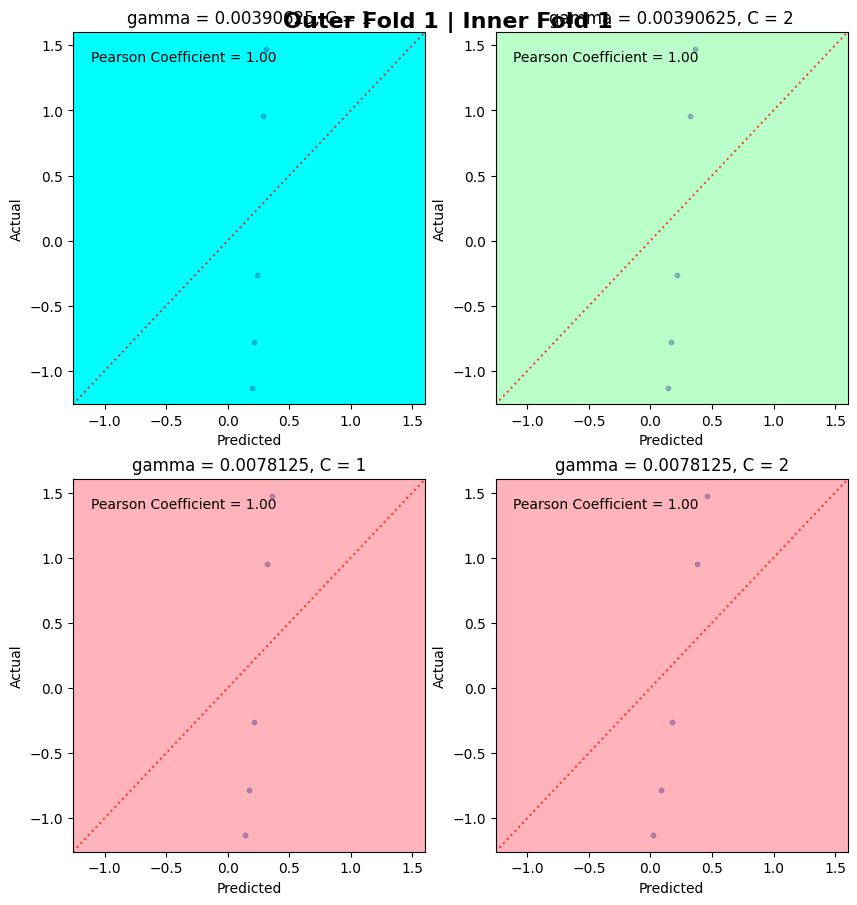

Average best parameters: 0.00390625, 1.0
Average best threshold: 0.03811888043819589
Super model predictions: 
          GY
2  -0.104412
4  -0.076791
6  -0.048962
7  -0.034994
9  -0.007001
10  0.007005
12  0.034987
13  0.048943
14  0.062862
19  0.131579
       GY
2   False
4   False
6   False
7   False
9   False
10  False
12   True
13   True
14   True
19   True


In [ ]:
# Real values
x_params_SVM_RO = mdo.AxisParams('gamma', bmo.power_list(2, -14, -6))
y_params_SVM_RO = mdo.AxisParams('C', bmo.power_list(2, -2, 6))

"""
# Quick test values
x_params_SVM_RO = mdo.AxisParams('gamma', bmo.power_list(2, -8, -7))
y_params_SVM_RO = mdo.AxisParams('C', bmo.power_list(2, 0, 1))
"""
metrics_SVM_RO = outer_CV_RO(5, 10, X_sc, y_sc, x_params_SVM_RO, y_params_SVM_RO, bmo.train_SVM_regressor, kfold_random_state=RANDOM_STATE, top_line_threshold=TOP_LINE_THRESH, kernel='rbf')

In [ ]:
# display metrics
display(metrics_SVM_RO)

In [ ]:
# Print average of each metric
metrics_SVM_RO_mean = metrics_SVM_RO.mean().to_frame().T
RO_average_metrics.loc['SVM'] = metrics_SVM_RO_mean.iloc[0]
display(metrics_SVM_RO_mean)

## XGBoost

In [ ]:
x_params_XGB_RO = mdo.AxisParams('n_estimators', [3, 7, 13, 25, 50, 100, 200])
y_params_XGB_RO = mdo.AxisParams('max_depth', [1, 2, 3, 4, 6, 10, 16, 32, 64])
metrics_XGB_RO = outer_CV_RO(5, 10, X_sc, y_sc, x_params_XGB_RO, y_params_XGB_RO, bmo.train_XGB_regressor, kfold_random_state=RANDOM_STATE, random_state=RANDOM_STATE, objective="reg:squarederror", eval_metric="rmse", top_line_threshold=TOP_LINE_THRESH)

In [ ]:
# display metrics
display(metrics_XGB_RO)

In [ ]:
# Print average of each metric
metrics_XGB_RO_mean = metrics_XGB_RO.mean().to_frame().T
RO_average_metrics.loc['XGB'] = metrics_XGB_RO_mean.iloc[0]
display(metrics_XGB_RO_mean)

In [37]:
# Save serialized session variables and models to disk for later use
dill.dump_session(f'{storage_dir}\\project_ipynb_env_RO.db')

# Conclusion

In [ ]:
# Plot average metrics for each model to compare GBLUP, SVM, and XGB
R_avg_metrics_plot = cmp.plot_model_metrics(R_average_metrics, "R")
R_avg_metrics_plot.savefig(f'{storage_dir}\\R_avg_metrics_plot.svg', format='svg')
plt.show(R_avg_metrics_plot)
plt.close(R_avg_metrics_plot)

B_avg_metrics_plot = cmp.plot_model_metrics(B_average_metrics, "B")
B_avg_metrics_plot.savefig(f'{storage_dir}\\B_avg_metrics_plot.svg', format='svg')
plt.show(B_avg_metrics_plot)
plt.close(B_avg_metrics_plot)

RO_avg_metrics_plot = cmp.plot_model_metrics(RO_average_metrics, "RO")
RO_avg_metrics_plot.savefig(f'{storage_dir}\\RO_avg_metrics_plot.svg', format='svg')
plt.show(RO_avg_metrics_plot)
plt.close(RO_avg_metrics_plot)